# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Data Analysis </strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
This notebook contains analysis of experiment results.
</p>


In [4]:
import os
import itertools
import re
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from globals import *

import warnings
from helper import format_number
warnings.filterwarnings("ignore")

In [5]:
csv_fpath = f"{DATA_PATH}/results.csv"
svo_fpath = f"{DATA_PATH}/svo_results.csv"
size_map  = {
    "XS" : 'transformer_iwslt_de_en',
    "S"  : 'transformer',
    'M'  : "transformer_vaswani_wmt_en_de_big"
    }

def add_features(fpath):
    """
    Adds features to csv found in fpath (should be results/svo_results.csv)

    Columns Added:
        - trained    (whether or not the model has been trained)
        - is multi   (whether or not len(src) > 1)
        - corpus_len (sum(corp_lens))
        - norm_steps (num steps normalized by corpus len)
        - model      (actual model name)
    """
    df = pd.read_csv(fpath)
    df['src'] = df['src'].apply(lambda lst : eval(lst))
    df['tgt'] = df['tgt'].apply(lambda lst : eval(lst))
    df['corp_lens'] = df['corp_lens'].apply(lambda lst : eval(lst))
    df['trained'] = ~df['bleu'].isna()
    df['is_multi'] = df['src'].apply(lambda src: len(src) > 1)
    df['corpus_len'] = df['corp_lens'].apply(lambda lst : sum(lst))
    df['norm_steps'] = df['num_steps'] / df['corpus_len'] # prop to num_epochs
    df['model'] = df['model_arch'].apply(lambda size : size_map[size])
    return df 

df  = add_features(csv_fpath)
svo = add_features(svo_fpath)

In [27]:
def plot_scores(df, x='corpus_len', score='bleu', color=None, threshold=-float('inf'), top_k=None, savefig=False, filename='plot', plot_desc=None, name_map=None):
    """
    Pplotting function that plots scores vs. x 

    df: df where all info is
    x: either corpus_len or size (for example corpus_len plots as you vary corpus length)
    score: scoring metric (bleu/chrF2 or svo_acc for svo_perm exp)
    color: color = c means color lines by value of col c 
    threshold: only plots score >= threshold
    top_k: only plots top_k scores
    savefig: whether or not to save fig 
    filename: name to save file as if savefig
    plot_desc: a description of the plot to add to the plot_info.json
    """
    df['src'] = df['src'].astype(str)
    df['tgt'] = df['tgt'].astype(str)

    if color is not None:
        unique_colors = df[color].unique()
        color_map = dict(zip(unique_colors, sns.color_palette("tab10", len(unique_colors))))
    else:
        colors = ['#00BFFF', '#228B22', '#FF6347', '#7851A9', '#FFA500', '#008080', '#708090']
        color_cycle = itertools.cycle(colors)

    markers = ['o', 's', '^', 'x', '*', '+', 'd']
    marker_cycle = itertools.cycle(markers)

    grouped = df.groupby(['src', 'tgt'])

    plt.figure(figsize=(25, 10))
    handles = []
    labels_scores = []  # to keep track of labels and their associated scores

    for (src_tgt, group) in grouped:
        if x == 'corpus_len':
            group['dataset_name'] = group['dataset_name'].apply(lambda x: re.sub(r'(_\d+\.?\d*k)$', '', x))
            name = group['dataset_name'].iloc[0]
            ### the score in the legend is the largest corp size all have been trained on
            common_max = min(group[x].max() for _, group in grouped)
            score_value = group[group[x] == common_max][score].iloc[0]
        elif x == 'size':
            name = group['dataset_name'].iloc[0]
            size_hierarchy = {'XS': 1, 'S': 2, 'M': 3}
            common_max_size = min(max(group['model_arch'].map(size_hierarchy)) for _, group in grouped)
            common_max_size_label = {v: k for k, v in size_hierarchy.items()}[common_max_size]
            score_value = group[group['model_arch'] == common_max_size_label][score].iloc[0]
        
        if score_value >= threshold:
            label_name = name if name_map is None else name_map[name]
            label = f"{label_name} : {score_value}"
            current_marker = next(marker_cycle)

            if color is not None:
                current_color = color_map[group[color].iloc[0]]
            else:
                current_color = next(color_cycle)

            sns.lineplot(data=group, x=x, y=score, label=label, color=current_color, errorbar=None)
            sns.scatterplot(data=group, x=x, y=score, color=current_color, marker=current_marker)
            handle = plt.Line2D([0], [0], marker=current_marker, color=current_color, label=label, linestyle='-')
            handles.append(handle)
            labels_scores.append((label, score_value, handle))

    # Sorting labels and scores to determine top_k
    labels_scores.sort(key=lambda x: x[1], reverse=True)
    if top_k is not None:
        labels_scores = labels_scores[:top_k]

    sorted_handles = [item[2] for item in labels_scores]  # Extract handles in sorted order

    plt.title(f"{score.title()} vs. {x.title()}")
    plt.xlabel(x.title())
    plt.ylabel(score.title())
    plt.grid(True)
    plt.legend(sorted_handles, [h.get_label() for h in sorted_handles], loc='center left', bbox_to_anchor=(1, 0.5), ncol=max(int(len(sorted_handles)//30),1))
    plt.tight_layout(rect=[0, 0, 0.75, 1])

    if savefig:
        plot_path = f"{PLOT_PATH}/{filename}.jpg"
        plt.savefig(plot_path)
        if plot_desc:
            update_metadata(filename, plot_desc)

    plt.show()

def update_metadata(filename, description):
    json_path = os.path.join(DATA_PATH, "plot_info.json")
    try:
        if os.path.exists(json_path):
            with open(json_path, 'r') as file:
                data = json.load(file)
        else:
            data = {}
        
        data[filename] = description

        with open(json_path, 'w') as file:
            json.dump(data, file)

    except Exception as e:
        print(f"Error updating plot description: {e}")

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> SVO Permutation Experiment </strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
The SVO permutation experiment trains pairwise the simple SVO languages. Specifically, let p1, p2 be distinct permutations of SVO. Then we train p1 -> p2 and p2 -> p1 for datasets of corpus length 1k, 2k, ..., 32k.
</p>


In [7]:
trained         = svo[svo['trained']]
trained['last'] = trained['tgt'].apply(lambda lst : lst[0].split('.')[0][-1])

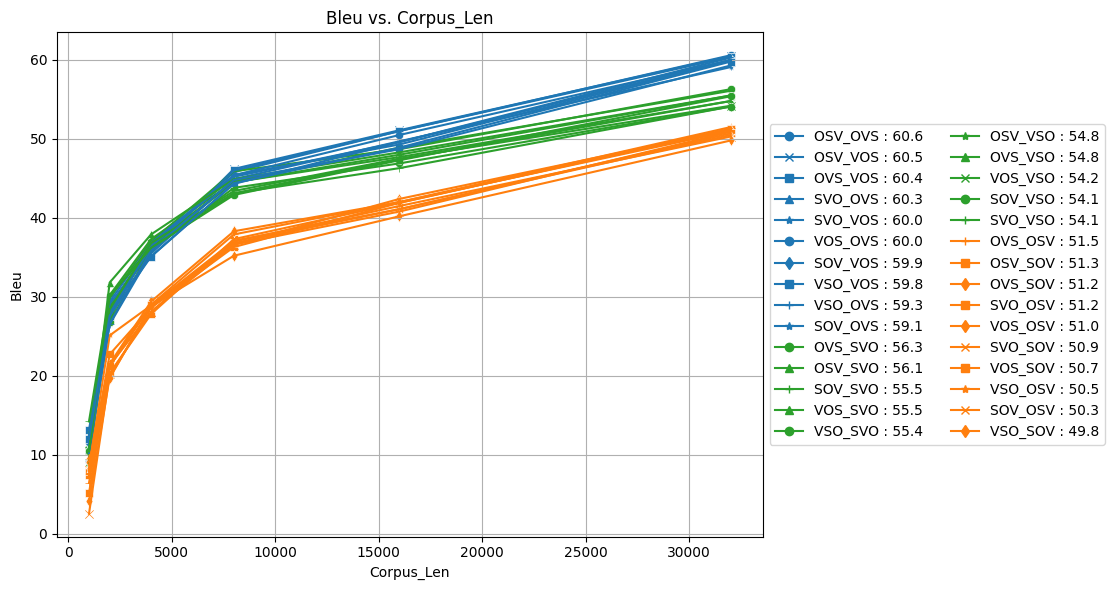

In [8]:
plot_desc = 'Plotting BLEU vs. corpus length for SVO perm experiment. Color coded by last letter of tgt language to highlight issue with BLEU as metric'
plot_scores(trained, color='last', savefig=True, filename='svo_perm_bleu', plot_desc=plot_desc)

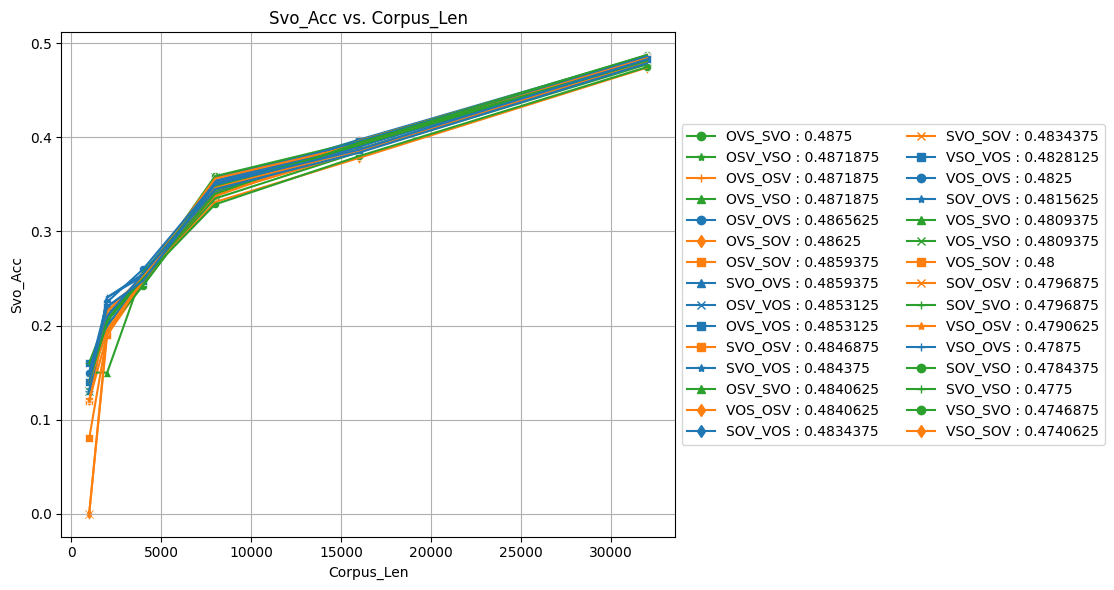

In [9]:
plot_desc = 'Plotting svo_acc vs. corpus length for SVO perm experiment. Color coded by last to show no longer trend.'
plot_scores(trained, score='svo_acc', color='last', savefig=True, filename='svo_perm_svo_acc', plot_desc=plot_desc)

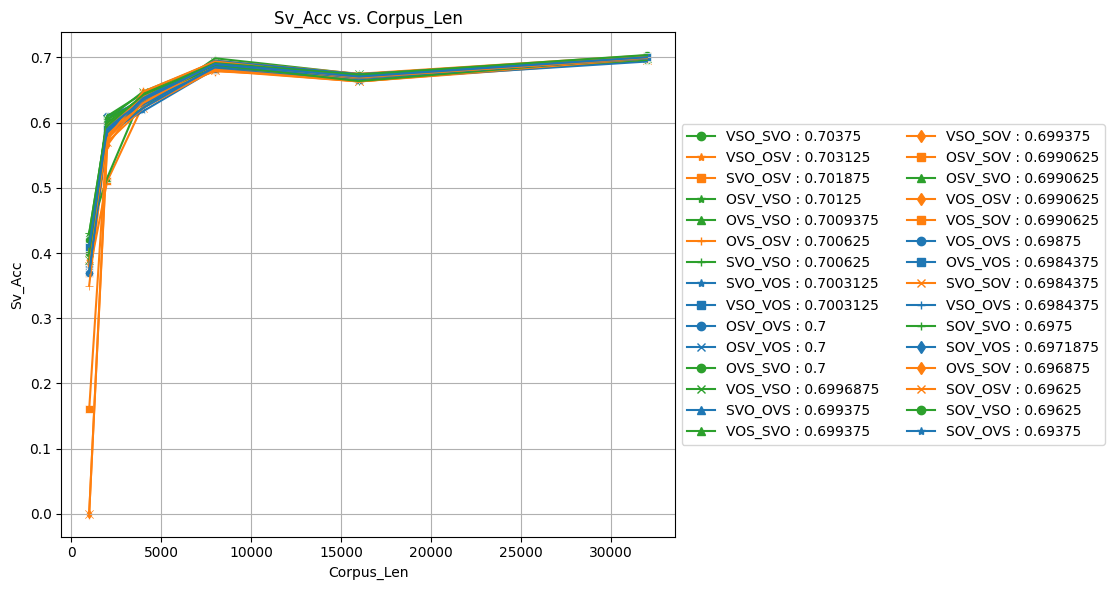

In [10]:
plot_desc = 'Plotting sv_acc vs. corpus length for SVO perm experiment. Color coded by last to show no longer trend.'
plot_scores(trained, score='sv_acc', color='last', savefig=True, filename='svo_perm_sv_acc', plot_desc=plot_desc)

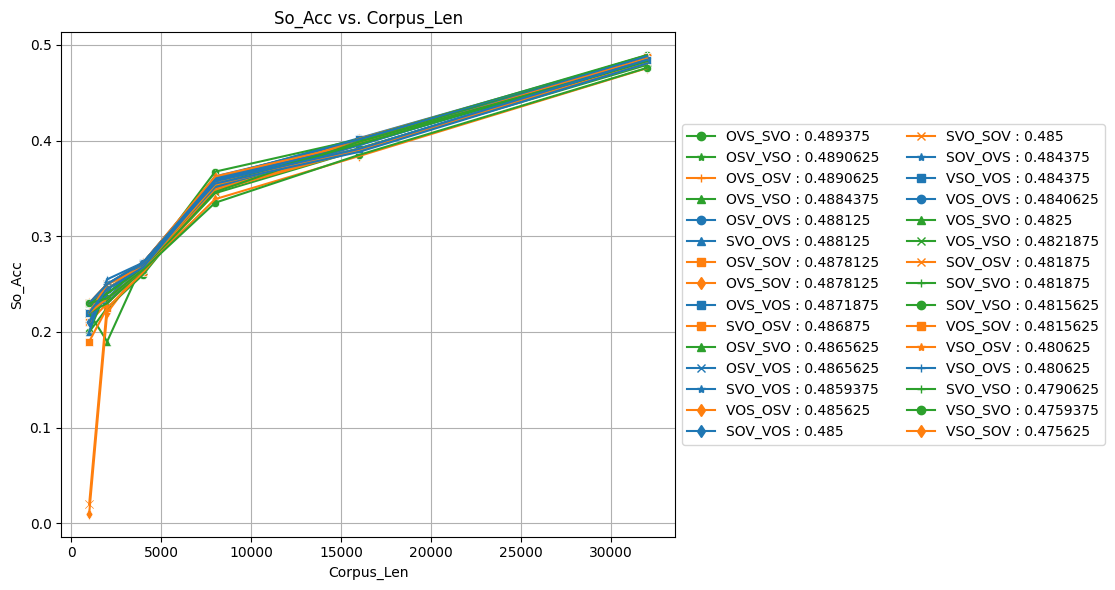

In [11]:
plot_desc = 'Plotting so_acc vs. corpus length for SVO perm experiment. Color coded by last to show no longer trend.'
plot_scores(trained, score='so_acc', color='last', savefig=True, filename='svo_perm_so_acc', plot_desc=plot_desc)

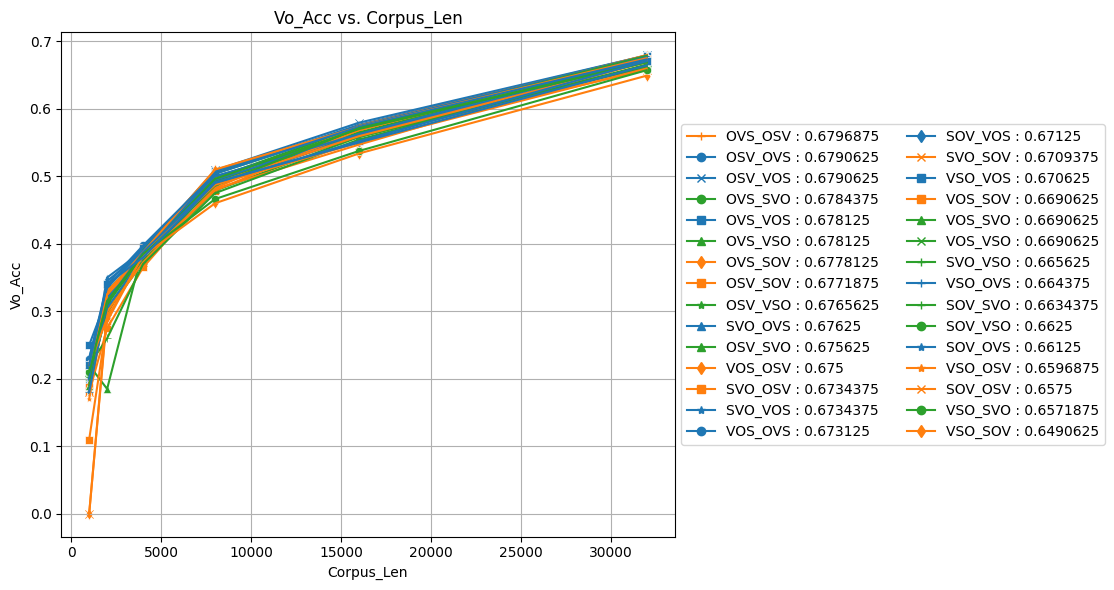

In [12]:
plot_desc = 'Plotting vo_acc vs. corpus length for SVO perm experiment. Color coded by last to show no longer trend.'
plot_scores(trained, score='vo_acc', color='last', savefig=True, filename='svo_perm_vo_acc', plot_desc=plot_desc)

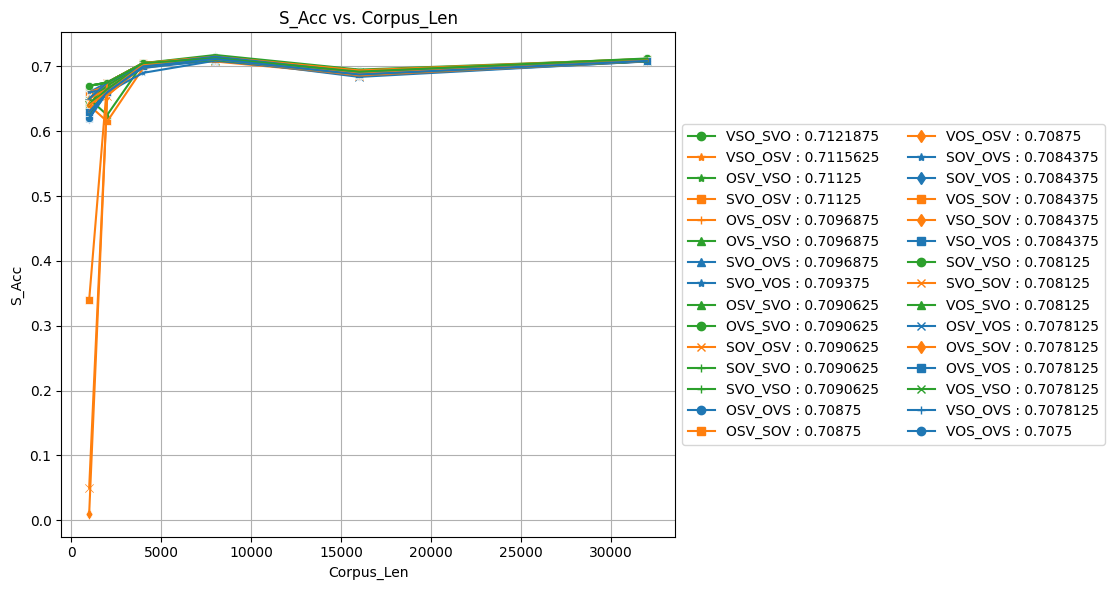

In [13]:
plot_desc = 'Plotting s_acc vs. corpus length for SVO perm experiment. Color coded by last to show no longer trend.'
plot_scores(trained, score='s_acc', color='last', savefig=True, filename='svo_perm_s_acc', plot_desc=plot_desc)

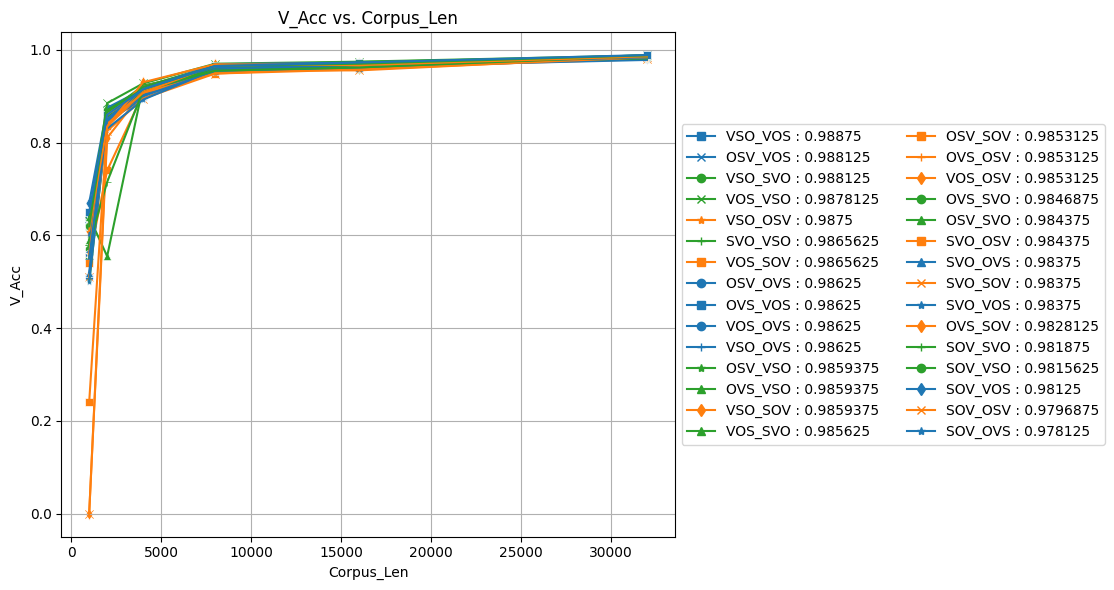

In [14]:
plot_desc = 'Plotting v_acc vs. corpus length for SVO perm experiment. Color coded by last to show no longer trend.'
plot_scores(trained, score='v_acc', color='last', savefig=True, filename='svo_perm_v_acc', plot_desc=plot_desc)

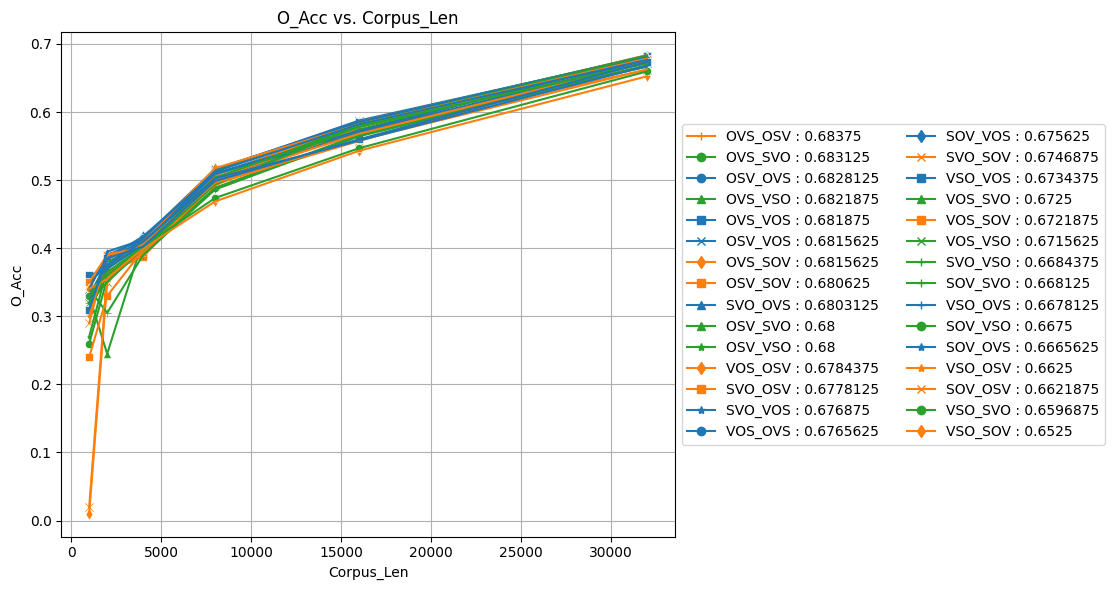

In [15]:
plot_desc = 'Plotting o_acc vs. corpus length for SVO perm experiment. Color coded by last to show no longer trend.'
plot_scores(trained, score='o_acc', color='last', savefig=True, filename='svo_perm_o_acc', plot_desc=plot_desc)

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Basic Multi Experiment </strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
The basic multi experiment begins to introduce multilingual datasets. Specifically we train 3 models for each corpus length: svo -> sov, svo/fr -> sov, fr -> sov. Really here we are looking at if svo -> sov (2k) performs worse than svo/fr -> sov (4k), i.e. seeing if the 2k fr sentences add synergy. 
</p>


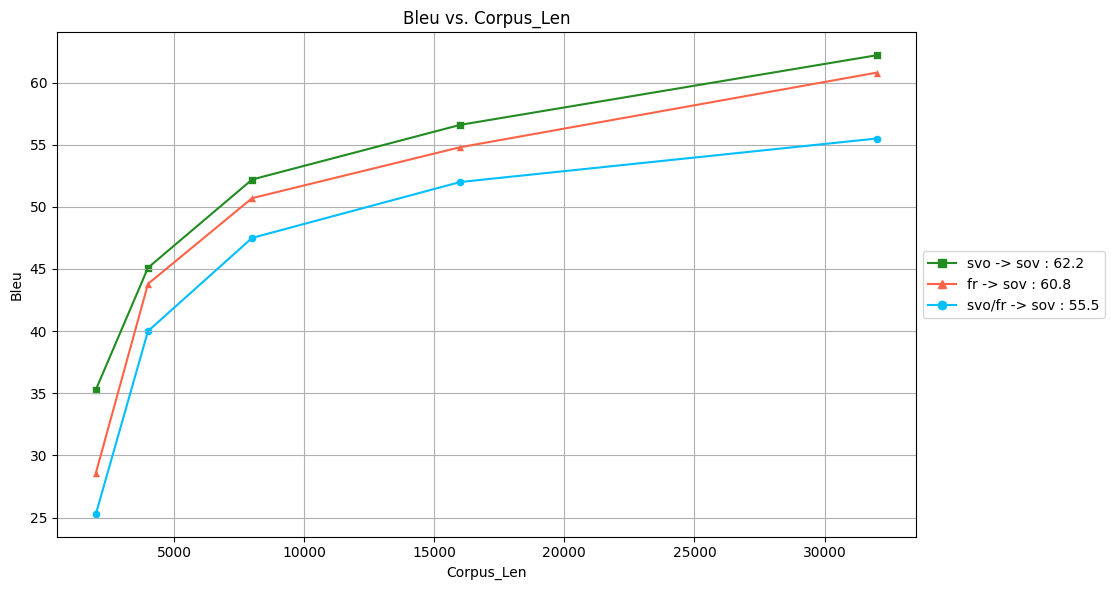

In [18]:
multi    = df[(df['trained']) & (df['exp_name'] == 'basic_multi')]
name_map = {
    "en_svo_en_sov" : 'svo -> sov',
    "en_svo_fr_en_sov" : 'svo/fr -> sov',
    'fr_en_sov'      : 'fr -> sov'
}

plot_desc = 'Plotting BLEU vs. corpus length for basic multi experiment. Notice the green at 4k is worse than the blue at 8k (synergy). But the blue at 16k is not better than the green at 8k.'
plot_scores(multi, name_map=name_map, savefig=True, filename='basic_multi', plot_desc=plot_desc)

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Switches Experiment </strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
The switches (new switches) experiment begins to introduce complex language. We specify a src language (switch 011101) and a tgt language (switch 000000). Then we train src + aux -> tgt, where aux is everything except src/tgt (including src2, a duplicate of src that differs in vocab).
</p>


In [52]:
def get_switches(df, condition='------'):
    ### gets new switches exp results if match condition (100---) has 100 and then last 3 can be anything
    data = df[(df['trained']) & (df['exp_name'] == 'new_switches')]

    # function to match the switch pattern
    def match_switch(switch, condition):
        condition = condition[:6]
        switch    = switch[:6]
        return all(c == '-' or c == switch[i] for i, c in enumerate(condition))

    data['switches'] = data['src'].apply(lambda lst : lst[-1].split('.')[0][1:])
    filtered_data = data[data['switches'].apply(lambda switch: match_switch(switch, condition))]
    return filtered_data 

def plot_switches(df=df, condition='------'):
    ### plot scores for certain conditions
    filtered_data = get_switches(df, condition)
    plot_scores(filtered_data)

def create_switches_df(df):
    ### df with mean scores 
    new_data = []

    for i in range(6):
        on = ['-' for _ in range(6)]
        on[i] = '1'
        on = ''.join(on)

        off = ['-' for _ in range(6)]
        off[i] = '0'
        off = ''.join(off)

        on_data = get_switches(df, condition=on)
        off_data = get_switches(df, condition=off)

        for c in on_data['corpus_len'].unique():
            on_c = on_data[on_data['corpus_len'] == c]
            off_c = off_data[off_data['corpus_len'] == c]

            # Calculate mean BLEU score for each switch state and corpus length
            mean_score_on = on_c['bleu'].mean()
            mean_score_off = off_c['bleu'].mean()

            # Add to new data
            new_data.append({'switch': i, 'parity': 1, 'corp_len': c, 'bleu': mean_score_on})
            new_data.append({'switch': i, 'parity': 0, 'corp_len': c, 'bleu': mean_score_off})

    # Create a new DataFrame
    new_df = pd.DataFrame(new_data)
    return new_df


def switches_barplot(df, lengths=[2000, 4000, 8000]):
    # Ensure the 'switch' and 'parity' columns are of type string
    df['switch'] = df['switch'].astype(str)
    df['parity'] = df['parity'].astype(str)

    # Filter the DataFrame for the specified corpus lengths
    df_filtered = df[df['corp_len'].isin(lengths)]

    # Setting up the figure
    fig, axes = plt.subplots(2, len(lengths) // 2, figsize=(12, 10))

    for i, length in enumerate(lengths):
        j = i // 2
        i = i % 2
        # Filter for the specific corpus length
        df_length = df_filtered[df_filtered['corp_len'] == length]
        min_bleu = df_length['bleu'].min() - 3
        max_bleu = df_length['bleu'].max() + 3
        # Create the barplot
        barplot = sns.barplot(data=df_length, x='switch', y='bleu', hue='parity', ax=axes[j][i])

        # Adding BLEU scores to bars
        for bar in barplot.patches:
            barplot.annotate(format(bar.get_height(), '.2f'), 
                             (bar.get_x() + bar.get_width() / 2, 
                              bar.get_height()), ha='center', va='center',
                              size=10, xytext=(0, 8),
                              textcoords='offset points')

        # Setting titles and labels
        axes[j][i].set_title(f'Corpus Length = {length}')
        axes[j][i].set_xlabel('Switch')
        axes[j][i].set_ylabel('BLEU Score' if i == 0 else '')
        
        # Set y-axis limits
        axes[j][i].set_ylim(min_bleu, max_bleu)

        # Adjust legend

    plt.tight_layout()
    plt.show()

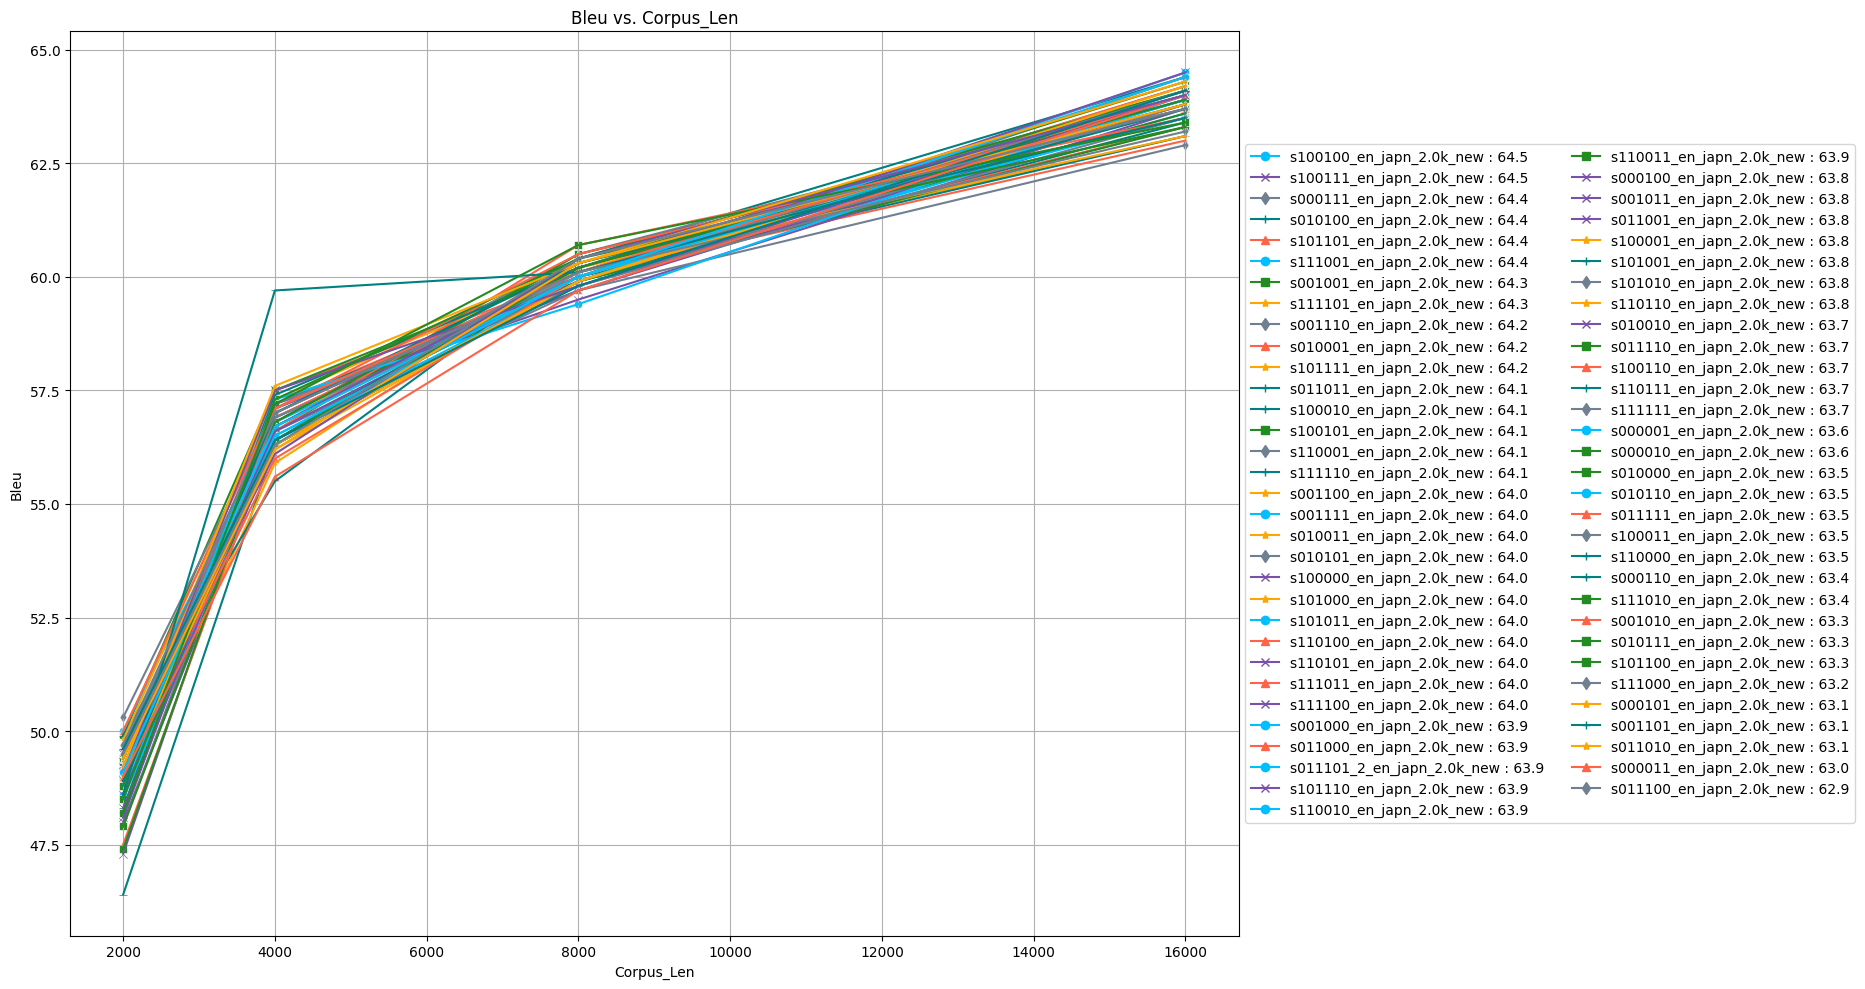

In [50]:
switches_df = df[df['trained'] & (df['exp_name'] == 'new_switches')]
plot_desc   = 'new switches scores results. The outlier is likely due to mistraining (I bumped epochs down to 300 which could cause this)'
plot_scores(switches_df, savefig=True, filename='new_switches_all_scores', plot_desc=plot_desc)

In [54]:
switches = create_switches_df(df)

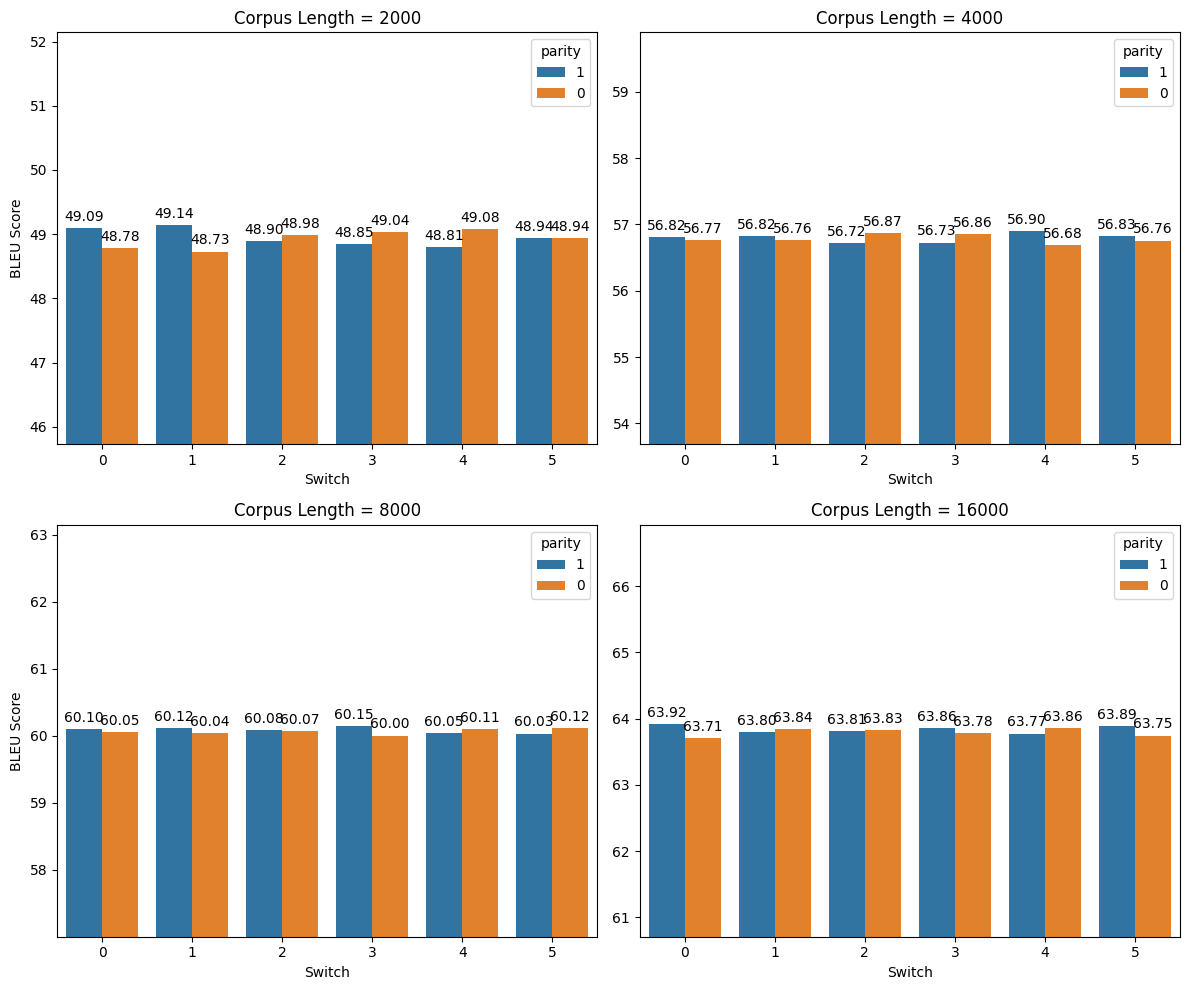

In [57]:
switches_barplot(switches, lengths=[2000,4000,8000,16000])